# Data exploration - credit card transactions

This is a data set taken [from kaggle](https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset). It claims to provide "detailed records of credit card transaction(s)". Additionally (and useful for our purposes), it also has a feature that reports whether the transaction was fradulent or not. Let's see what information we can gleam from this data before trying to apply any models to detect fraud.

In [1]:
# Getting our imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display, HTML
import warnings


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# from scikeras.wrappers import KerasClassifier #Requires pip install scikeras!!!!

# let's disable warnings while we're here too.
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [2]:
# Let's set up a convenenience function for our headers. Feel free to ignore this cell
def display_header(header_text, size="H2"):
    display(HTML(f"<{size}>{header_text}</{size}>"))

# Basic overview of the data

In [3]:
df = pd.read_csv("../data/raw/credit_card_transactions.csv")

In [4]:
# df.columns.to_list()

In [5]:
display_header("Basic Overview")
display(df.head(5))

display_header("Data Description")
display(df.describe())

display_header("Null Values")
null_count = df.isnull().sum()
display(null_count[null_count > 0].to_frame())
display(HTML("It appears we have a null value. We need to be mindful of that."))

display_header("Duplicates")
duplicates = df.duplicated().sum()
display(duplicates)
display(HTML("No duplicates found. That should make data cleaning a bit easier."))


display_header("Data Shape")
display(HTML(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}"))


display_header("Unique Values")
unique_values = pd.DataFrame({
"Column Names": df.columns,
"Data Types": [df[col].dtype for col in df.columns],
"Unique Value Count": [df[col].nunique() for col in df.columns]
})
display(unique_values)
display(HTML("""Not really a big deal, but it looks like those objects are all strings.
              Not an issue, but worth mentioning."""))

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.100702e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03,4.682575e+04
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02,2.583400e+04
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00,1.001000e+03
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00,2.511400e+04
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00,4.586000e+04
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00,6.831900e+04
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00,9.940300e+04


,0
merch_zipcode,195973


0

,Column Names,Data Types,Unique Value Count
0,Unnamed: 0,int64,1296675
1,trans_date_trans_time,object,1274791
2,cc_num,int64,983
3,merchant,object,693
4,category,object,14
5,amt,float64,52928
6,first,object,352
7,last,object,481
8,gender,object,2
9,street,object,983


# Graphs and analysis
Let's visualize some of the data here and see if we can find anything interesting

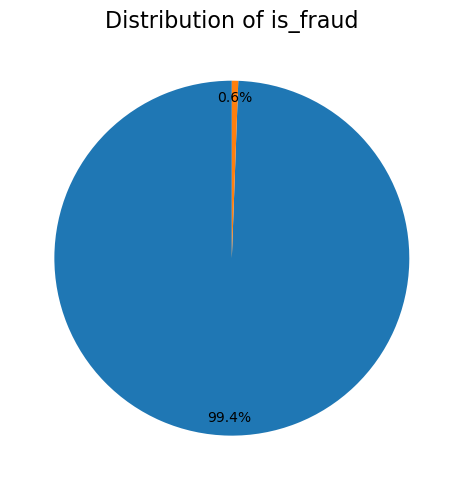

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

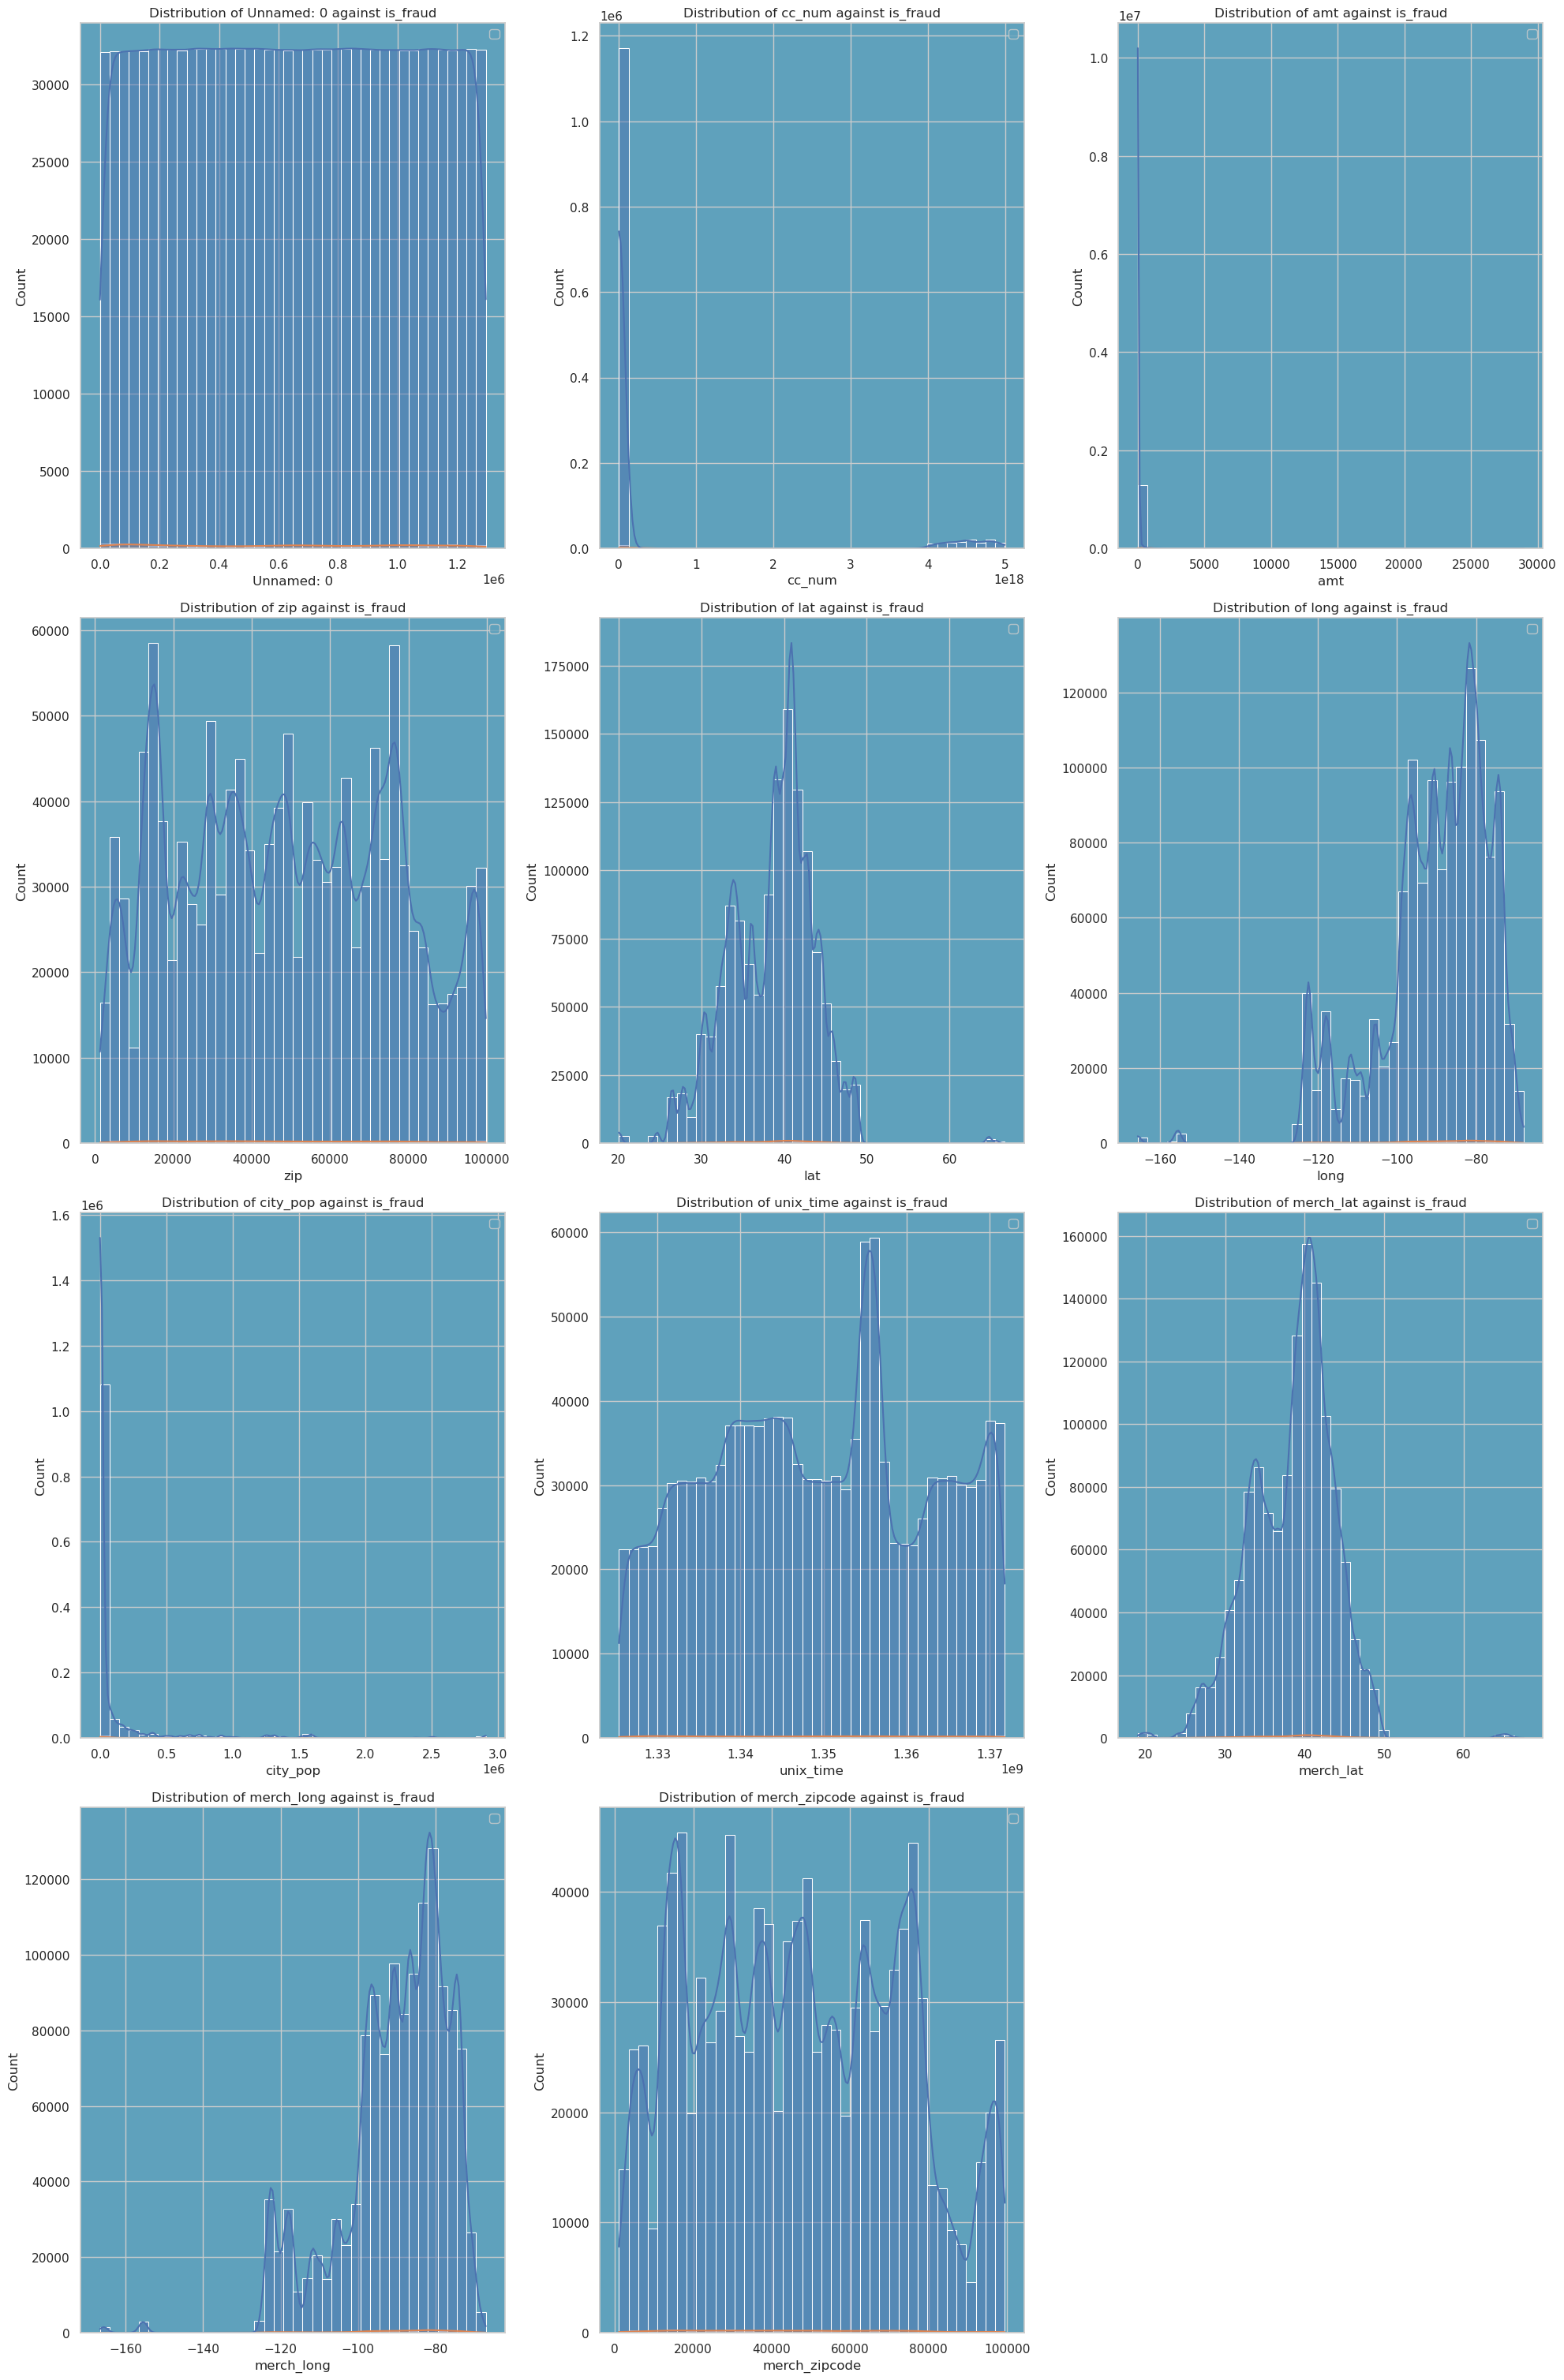

In [6]:
def single_plot_distribution(df, column_name):
    value_counts = df[column_name].value_counts()
    fig, ax1 = plt.subplots(1, figsize=(15, 5), gridspec_kw={"width_ratios": [1]}) 
    ax1.pie(value_counts, startangle=90, autopct="%0.001f%%", pctdistance=0.9, labels=None)
    ax1.set_title(f"Distribution of {column_name}", fontsize=16)

    plt.tight_layout()
    plt.show()

single_plot_distribution(df, "is_fraud")

display(HTML("""It seems that we have a massive difference between the number of values that
             are record as fraud and those that aren't. We <b>must</b> be mindful of sampling"""))


def create_subplots(df, columns, hue, theme_style, theme_rc, figsize=(15, 10)):
    sns.set_theme(style=theme_style, rc=theme_rc)
    
    num_columns = len(columns)
    num_rows = (num_columns + 2) // 3

    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    axes = axes.flatten()
    
    plot_index = 0
    for col in columns:
        if col == hue:
            continue
        
        if df[col].dtype == object: # we can't exactly plot strings. This _would_ be a good chance to improve with categories though
            continue
        sns.histplot(data=df, x=col, hue=hue, bins=40, edgecolor="white", kde=True, ax=axes[plot_index])
        
       
        axes[plot_index].set_title(f"Distribution of {col} against is_fraud")
        axes[plot_index].set_xlabel(col)
        axes[plot_index].set_ylabel("Count")
        axes[plot_index].legend()
        
        plot_index += 1
    
    # Remove extra axes
    for j in range(plot_index, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


columns = df.columns.to_list()  

create_subplots(df=df, columns=columns, hue="is_fraud", 
                theme_style="whitegrid", theme_rc={"axes.facecolor": "#5fa1bc"}, 
                figsize=(20, 60))



# Creating a model

So, we have some baseline exploration done. Let's see if we can create a model for decent predictions of a fraud case.



In [7]:
# drop the unamed column which is useless data
df = df.drop(columns=["Unnamed: 0"])

# additionally, there are some columns that aren't particularly useful. Let's drop them too
# trans_time, num, dop/first/last aren't useful. Or at least, I don't think they are
df = df.drop(columns=["trans_date_trans_time", "trans_num", "dob", "first", "last"])

# fill the null values with a -1 placeholder
df["merch_zipcode"] = df["merch_zipcode"].fillna(-1)  # Using -1 as a placeholder for missing values


# let's create our data:
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]


# List of categorical columns
categorical_features = ["merchant", "category", "gender", "city", "state", "job"]
numerical_features = ["amt", "unix_time", "cc_num", "zip", "lat", "long", "city_pop", "merch_lat", "merch_long", "merch_zipcode"]

# Create our pre-processor. one-hot encode our categorical features
# and scale the numerical ones appropriately.

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)


In [8]:
# Create a model with Keras so we can wrap it into our SKLearn pipeline
# edit: Couldn't get this to work. Maybe someone else on my team can :(

# def create_model(optimizer="Adam", kernel_initializer="glorot_uniform", dropout=0.2, n_outputs_expected=16):
#     model = Sequential()
#     model.add(Dense(16, activation="relu", kernel_initializer=kernel_initializer, input_shape=(n_outputs_expected,))) # 16 features, 16 initial entries
#     model.add(Dense(32, activation="relu"))
#     model.add(Dense(32, activation="relu"))
#     model.add(Dropout(dropout))
    
#     model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["categorical_accuracy"])
#     return model



# wrapped = KerasClassifier(build_fn=create_model, validation_split = 0.1, n_outputs_expected=1, batch_size=16)
# dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# regr_1 = DecisionTreeRegressor(max_depth=4)
# regr_2 = AdaBoostRegressor(
#     DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=8200
# )

In [9]:
# Split the data as best as possible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8200)


pipeline = Pipeline(
    steps= [
        ('preprocessor', preprocessor),
        ("refressor", DecisionTreeClassifier())
    ]
)

history = pipeline.fit(X_train, y_train)

res = history.predict(X)



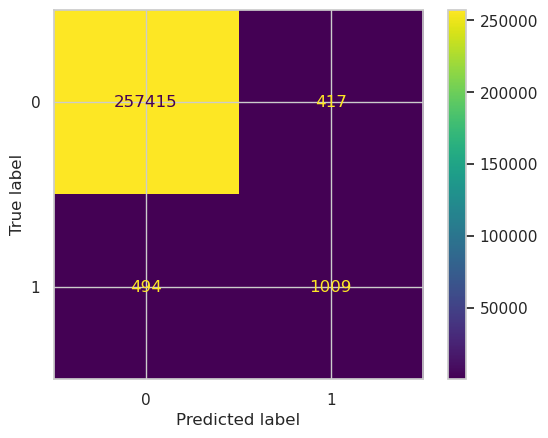

0.996487169105597
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257832
           1       0.71      0.67      0.69      1503

    accuracy                           1.00    259335
   macro avg       0.85      0.83      0.84    259335
weighted avg       1.00      1.00      1.00    259335



In [10]:
res = history.predict(X_test)

display_header("Results")

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, res), display_labels = [0, 1]) 

cm_display.plot()
plt.show() 

print(accuracy_score(y_test, res))
print(classification_report(y_test, res))


y_prob = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

display(HTML("<p>not bad overall I'm out of time and can't create a proper analysis against the remaining data, but this overall looks...promising?</p>"))
